# Visualizing NDT & Paris-Traceroute in Africa

This Jupyter notebook visualizes M-Lab test data in Africa. Using BigQuery, we select NDT or paris-traceroute data from clients in Africa. Then, using a world map from Natural Earth and the GeoDataFrame Python packages, we plot the African data using geolocation hints from the data.

### Setup

To do this, we need to install and configure some local dependencies first.

* Install [Jupyter](http://jupyter.org/install)
* Install [gcloud SDK](https://cloud.google.com/sdk/downloads) 
* Setup gcloud SDK

```
# Authenticate your account.
gcloud auth login

# Set default project.
gcloud config set project measurement-lab
```

* Install [google-cloud-bigquery](https://pypi.org/project/google-cloud-bigquery/) package:
  
```
pip install --upgrade google-cloud-bigquery
```

* Install [GeoPandas](http://geopandas.org/install.html) and dependencies

```
pip install geopandas PySAL descartes
```

* Download Natural Earth "Admin 0 - Countries" shape files

  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
  
* Unzip ne_10m_admin_0_countries.zip 

```
cd ~/Downloads
unzip ne_10m_admin_0_countries.zip
```

* Start Jupyter

```
jupyter-notebook
```
 
### References

* Matplotlib - https://matplotlib.org/contents.html
* Pandas - https://pandas.pydata.org/pandas-docs/stable/api.html 
* BigQuery - https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators 
* GeoPandas - http://geopandas.org/index.html

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
from shapely import geometry

# Ignore warnings from various packages.
import warnings
warnings.filterwarnings("ignore")

# Set project explicitly in the environment to suppress some warnings.
os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

# Load M-Lab site metadata including site latitude & longitude.
mlab_sites_config = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

# Short list of metros in Africa, for convenience.
african_metros = ['tun', 'jnb', 'cpt', 'mpm', 'tnr', 'los', 'nbo', 'acc']

# Load the Natural Earth country shapes file.
country_shapes = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

# Number of colors to use when coloring maps.
colors = 10

# Default figure size. W x H.
figsize = (16, 10)

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=600):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [3]:
# Load shape data.
globe_raw = gpd.read_file(country_shapes)

# Select the global information (except Antarctica).
globe = globe_raw[['ISO_A2', 'CONTINENT', 'geometry']].to_crs('+proj=longlat')
globe = globe[globe.CONTINENT != 'Antarctica']
# Add a new column with a default value of zero to show countries without data.
globe['default'] = 0

# Select only Africa.
africa = globe[globe.CONTINENT == 'Africa'].copy()
africa['default'] = 0
africa.sample(5)

,ISO_A2,CONTINENT,geometry,default
102,AO,Africa,(POLYGON ((13.07370284000007 -4.63532318099996...,0
101,BJ,Africa,"POLYGON ((3.596400187000114 11.69577301000001,...",0
107,BW,Africa,POLYGON ((25.25978072100012 -17.79410654699998...,0
144,LS,Africa,POLYGON ((28.98084558100007 -28.90903533899998...,0
19,TZ,Africa,(POLYGON ((32.9208634850001 -9.407900085999913...,0


# NDT in Africa

How many NDT tests are clients in Africa running to M-Lab servers?

By default, the [M-Lab naming service](https://mlab-ns.appspot.com) directs clients to the geographically closes M-Lab server. The idea is to use geographic proximity as a proxy for network proximity. So, we expect to see more tests near M-Lab servers.

For a given day, the query below counts all tests from clients in Africa. At the same time we calculate the average download rate per country for all clients.

In [4]:
rates_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count,
  AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked /
      (web100_log_entry.snap.SndLimTimeRwin +
       web100_log_entry.snap.SndLimTimeCwnd +
       web100_log_entry.snap.SndLimTimeSnd))) AS download_Mbps
       
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND connection_spec.client_geolocation.continent_code = "AF"

  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND web100_log_entry.snap.CongSignals > 0
  AND (web100_log_entry.snap.State = 1 OR
    (web100_log_entry.snap.State >= 5 AND
    web100_log_entry.snap.State <= 11))
  
GROUP BY
  country_code, country_name

HAVING
  count > 100

ORDER BY
 country_name, country_code, count desc
""")

In [5]:
# Now `rates_df` contains all results from the BigQuery results in the form of a Pandas DataFrame.
rates_df.sample(5)

,count,country_code,country_name,download_Mbps
5,3001,MA,Morocco,5.918805
8,120,TZ,Tanzania,1.249333
4,162,MG,Madagascar,16.446735
3,1702,KE,Kenya,5.796839
7,12824,ZA,South Africa,9.959014


In [6]:
# Merge the africa dataframe with the rates_df using the 2-letter country codes in both.
rates_merged = africa.merge(rates_df, left_on='ISO_A2', right_on='country_code')
rates_merged.sample(5)

,ISO_A2,CONTINENT,geometry,default,count,country_code,country_name,download_Mbps
1,TZ,Africa,(POLYGON ((32.9208634850001 -9.407900085999913...,0,120,TZ,Tanzania,1.249333
7,UG,Africa,POLYGON ((30.47178584300013 -1.066836591999916...,0,217,UG,Uganda,2.270746
6,DZ,Africa,POLYGON ((-4.821613117999902 24.99506459600009...,0,385,DZ,Algeria,1.787968
0,KE,Africa,(POLYGON ((34.38118778500007 4.620158386000099...,0,1702,KE,Kenya,5.796839
3,ZA,Africa,(POLYGON ((19.98144657400005 -24.7524931839999...,0,12824,ZA,South Africa,9.959014


### Test Counts

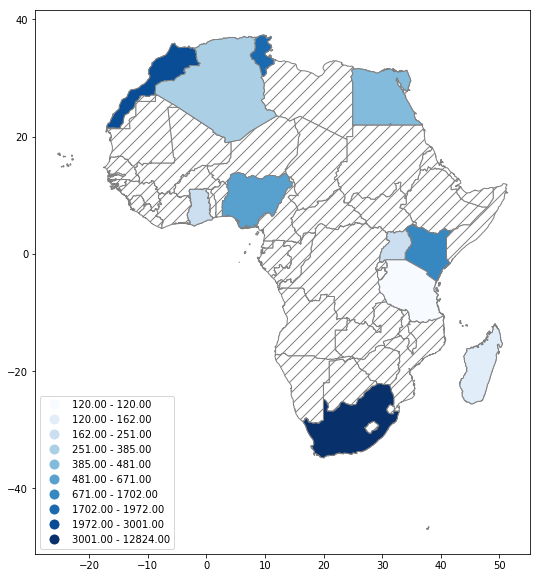

In [7]:
# First, plot the plain African map with hatch marks so all countries are represented.
ax0 = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
# Next, plot the merged rates dataframe on top of the base map. Only countries with data will be shown.
_ = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                      k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')

### M-Lab Metro Locations

While the map above highlights countries where *users* are running NDT tests, it does not reveal the location of M-Lab servers used to run those tests.

To add M-Lab server locations to the map, next we will loads the M-Lab site configuration for Africa.

In [8]:
# Download the M-Lab site configuration.
response = urllib2.urlopen(mlab_sites_config)
sites = json.loads(response.read())

# Collect all sites in Africa, creating a geometry.Point for each one.
all_map = {}
africa_map = {}
for row in sites:
    metro = row['site'][0:3]
    all_map[metro] = (metro, geometry.Point(row['longitude'], row['latitude']))
    if metro in african_metros:
        africa_map[metro] = all_map[metro]

# Convert the dict into a GeoDataFrame.
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    all_map, orient='index', columns=['metro', 'location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    africa_map, orient='index', columns=['metro', 'location']), geometry='location')

In [9]:
print africa_locations.keys()

Index([u'metro', u'location'], dtype='object')


### Test Counts With M-Lab Metro Locations

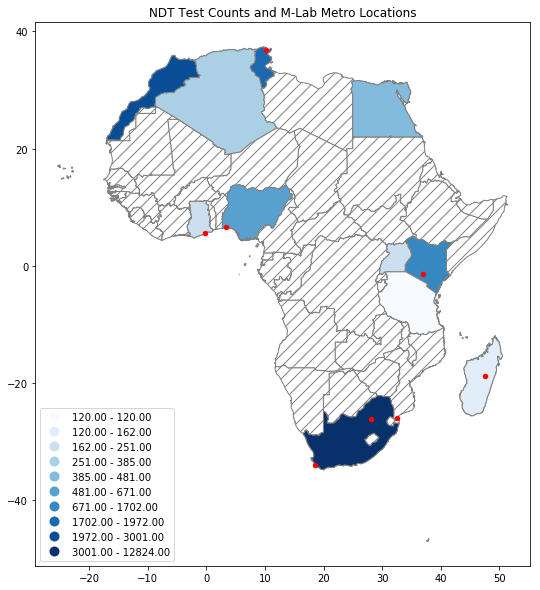

In [10]:
# Repeat the steps for plotting Africa test counts.
ax0 = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax1 = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
# Add the M-Lab metro locations.
africa_locations.plot(ax=ax1, color='red', markersize=20)
_ = ax1.set_title('NDT Test Counts and M-Lab Metro Locations')

### NDT Test Rates

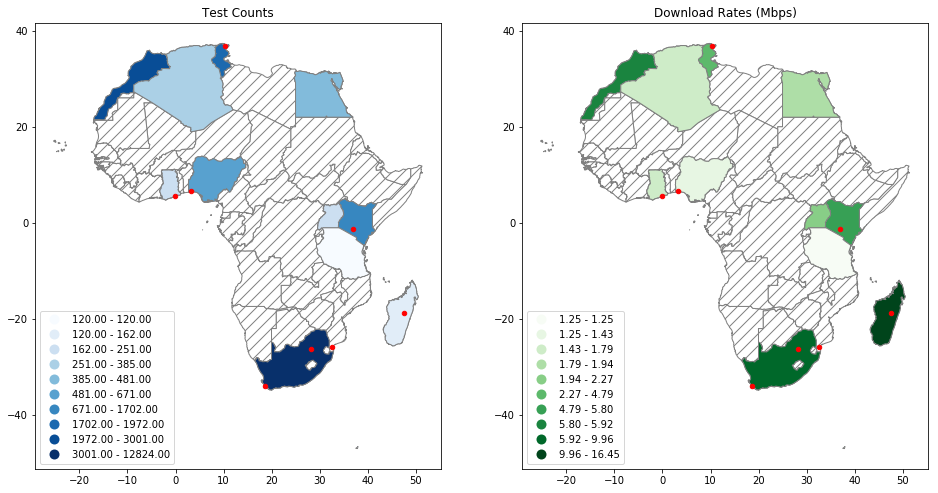

In [11]:
f, ax = plt.subplots(1, 2, figsize=figsize)

ax0 = africa.plot(ax=ax[0], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax1 = rates_merged.plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
africa_locations.plot(ax=ax1, color='red', markersize=20)

ax0 = africa.plot(ax=ax[1], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax2 = rates_merged.plot(ax=ax0, column='download_Mbps', cmap='Greens', scheme='Fisher_Jenks',
                        k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
africa_locations.plot(ax=ax2, color='red', markersize=20)

_ = ax1.set_title('Test Counts')
_ = ax2.set_title('Download Rates (Mbps)')

# Paris-Traceroute in Africa

How are clients in Africa routed to M-Lab servers?

Every time a client machine contacts and M-Lab server, the server starts a paris-traceroute from the M-lab server to the client remote IP. Each paris-traceroute hop is annotated with geo-location metadata for the intermediate router IP address, including the country. 

For a given day, the query below counts the hops in all countries visited between all clients in Africa and the African M-Lab server they contacted.

In [12]:
df_hops = {}
for metro in african_metros:
    print metro,
    df_hops[metro] = run_query("""
SELECT 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  COUNT(*) as hops
  
FROM
  `measurement-lab.traceroute.base`
  
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-16")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"
  AND (REGEXP_CONTAINS(test_id, ".*3010.paris.gz") OR REGEXP_CONTAINS(test_id, ".*3001.paris.gz"))

GROUP BY
  dest_country_code

ORDER BY
  hops desc
""" % metro)

tun jnb cpt mpm tnr los nbo acc


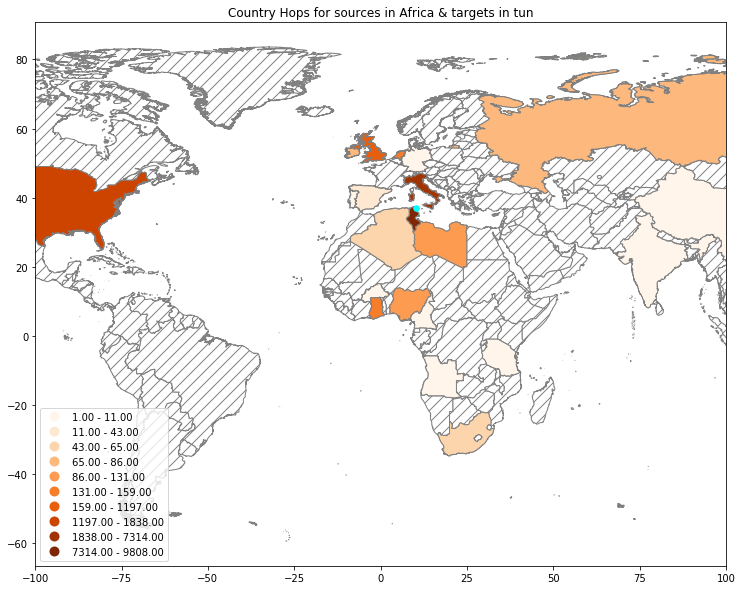

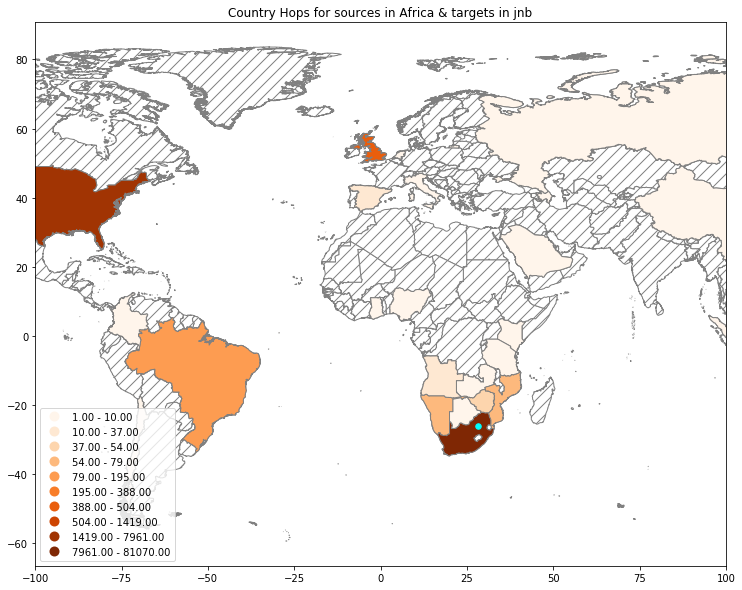

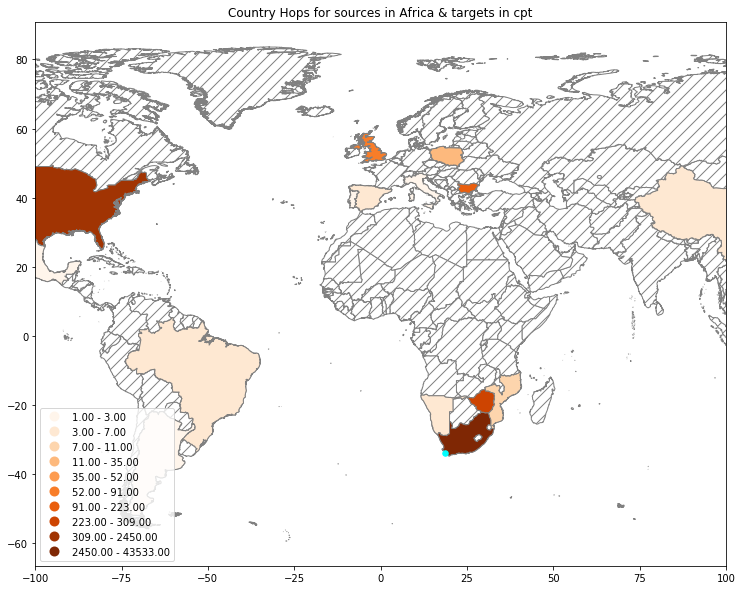

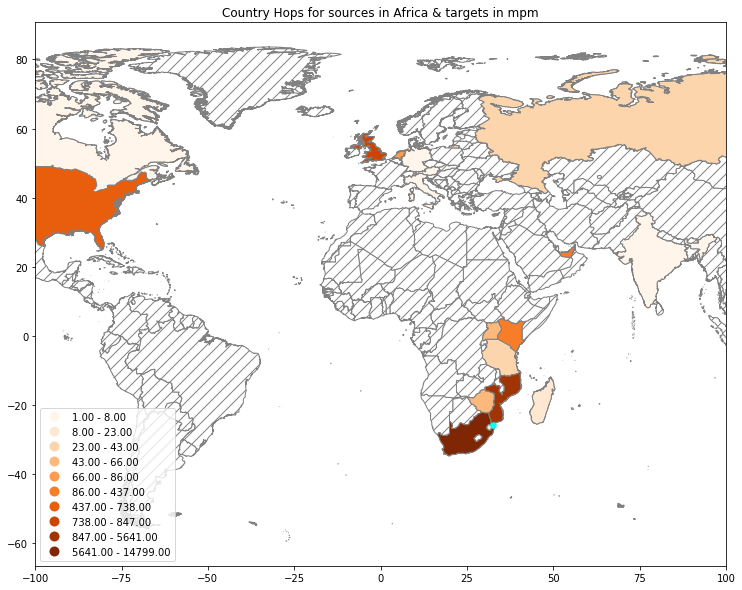

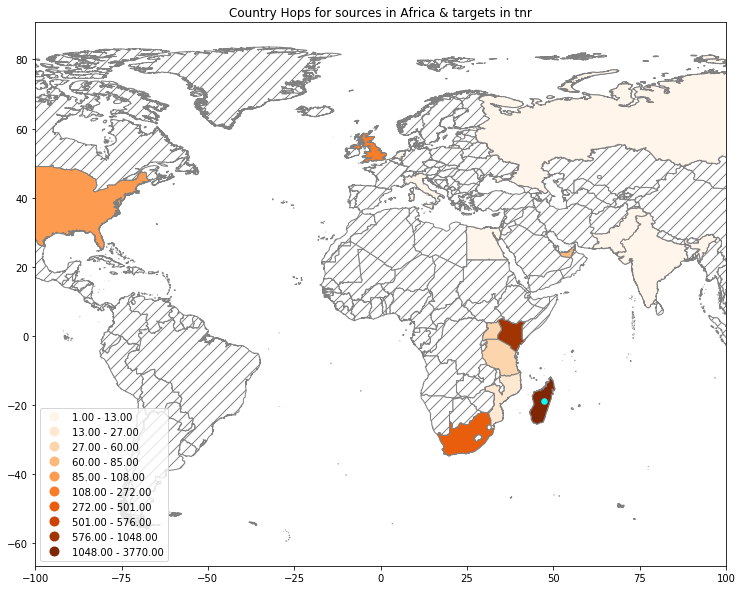

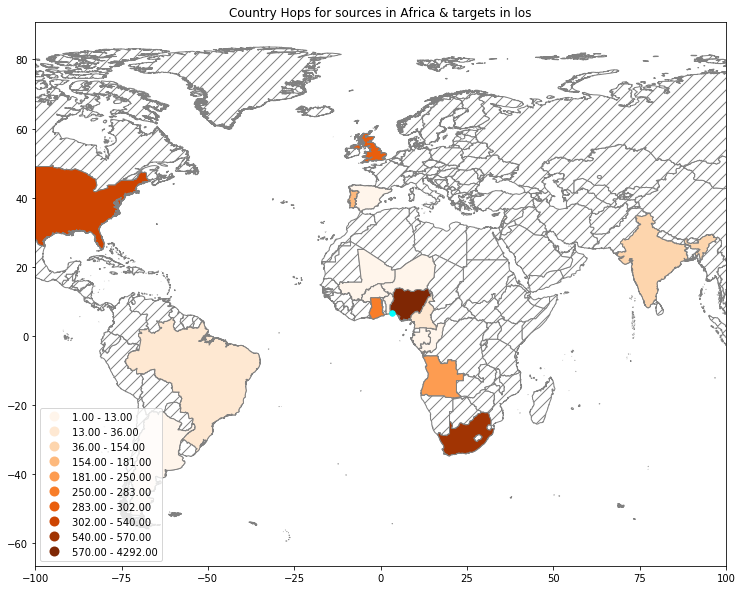

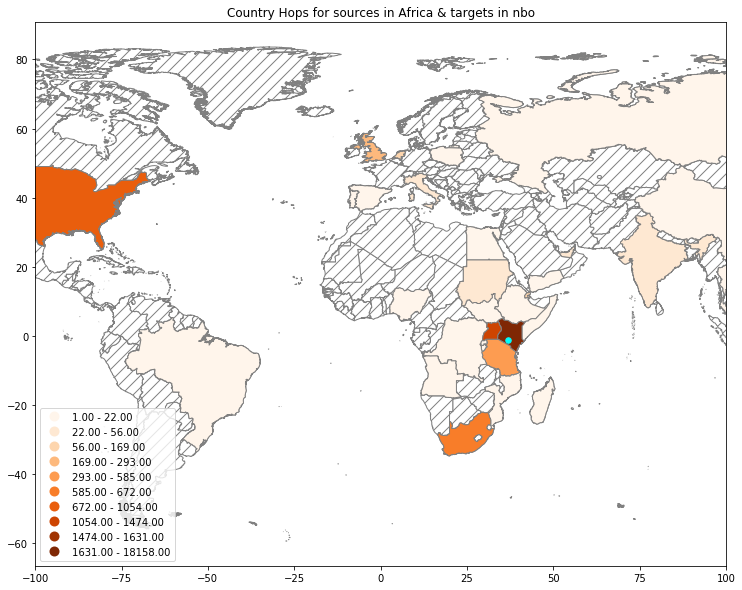

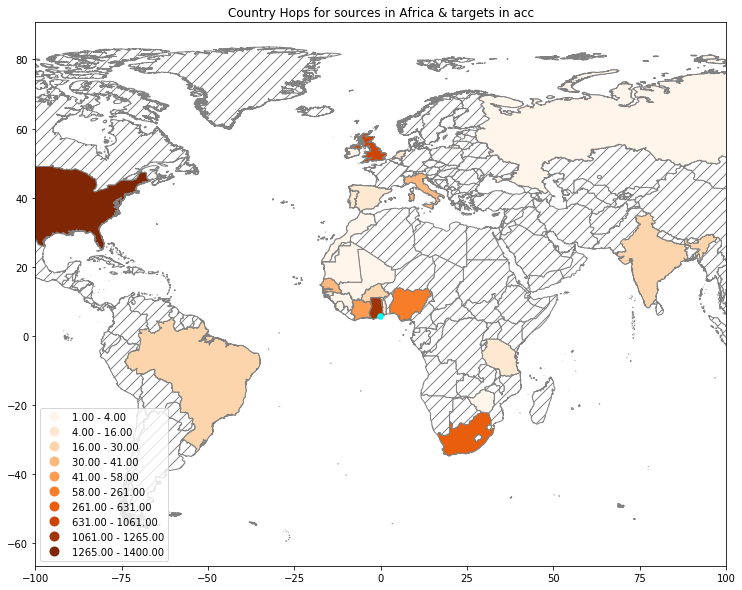

In [13]:
for metro in african_metros:
    if not len(df_hops[metro]):
        print "Skipping %s" % metro
        continue

    hops_merged = globe.merge(df_hops[metro], left_on='ISO_A2', right_on='dest_country_code')

    ax1 = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
    ax2 = hops_merged.plot(ax=ax1, column='hops', cmap='Oranges', scheme='Fisher_Jenks',
                           k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
    ax2.set_title('Country Hops for sources in Africa & targets in %s' % metro)
    africa_locations[africa_locations.metro == metro].plot(ax=ax2, color='cyan', markersize=30)
    ax2.set_xbound(-100, 100)